# Load in Libraries

In [1]:
import numpy as np
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

# Manage DataFrames
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import RepeatedKFold

# Normalize
from sklearn.preprocessing import StandardScaler

# Gridsearch

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

Load in Data and define x,y

In [2]:
df = pd.read_csv("Exercise2BusData.csv")


In [3]:
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)
df.head(10000)

,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,39,-4,28.641509
1,168,0,39,181,27.880597
2,231,0,39,244,27.852941
3,150,17,39,143,27.826087
4,965,35,51,947,42.029412
...,...,...,...,...,...
2174,123,10,51,128,34.189873
2175,78,0,51,95,34.197531
2176,86,23,51,82,35.414634
2177,121,10,51,119,35.373494


Remove outlier

<AxesSubplot:xlabel='Arrival_delay'>

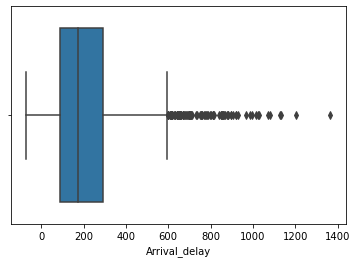

In [4]:
sns.boxplot(x=df['Arrival_delay'])

In [5]:
n=42131
std2019=df['Arrival_delay'].std()
mean=df['Arrival_delay'].mean()

outliers=[]
for i in df['Arrival_delay']:
    z=abs((i-mean)/std2019)
    if z > 3:
        outliers.append(i)
        df.drop(df[df["Arrival_delay"]==i].index, inplace=True)
        

outliers=pd.DataFrame(outliers)
outliers.describe()

,0
count,42.000000
mean,912.023810
std,130.717623
min,761.000000
25%,812.500000
50%,872.000000
75%,980.750000
max,1365.000000


In [6]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']
# Feature Engineering
df['Dwell_Scheduled_ratio'] = df['Dwell_time'] / df['Scheduled_travel_time']
df['Upstream_Scheduled_ratio'] = df['Upstream_stop_delay'] / df['Scheduled_travel_time']
df['Total_Upstream_Recurrent'] = df['Upstream_stop_delay'] + df['Recurrent_delay']

# Splitting
train_X, test_X, train_y, test_y = train_test_split(x, y,
                      test_size = 0.20, random_state = 123)

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)


In [7]:
param_grid = {
    'n_estimators': [50, 100, 2000], # Number of trees
    'max_depth': [1, 3, 9], # depth of each tree
    'eta': [0.01, 0.05, 0.3] # learning rate
}
# creating the model
xgb_model = XGBRegressor()
# using the grid parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# grid search to the data
grid_search.fit(train_X_scaled, train_y)

# best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict using the best model
best_pred = best_model.predict(test_X_scaled)

# Compute RMSE
best_rmse = np.sqrt(MSE(test_y, best_pred))
print("Best RMSE:", best_rmse)

# Print the best parameters
print("Best Parameters:", best_params)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best RMSE: 13.577898121089042
Best Parameters: {'eta': 0.05, 'max_depth': 1, 'n_estimators': 2000}


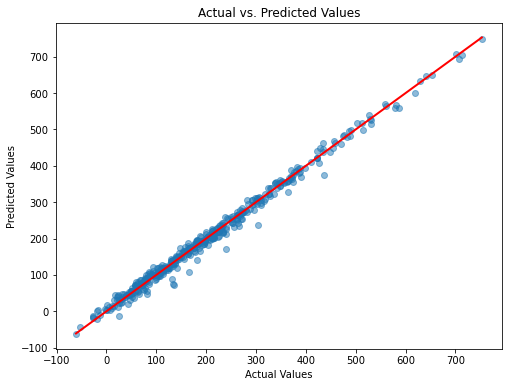

In [8]:
pred=best_pred
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(test_y, pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='-', color='red', lw=2)

# Show the plot
plt.show()